**Project | NLP Challenge**

Group: Lexnova

In [2]:
import nltk
import re
import string
import joblib
import gensim
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk import pos_tag
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense, SpatialDropout1D, GlobalMaxPooling1D, LSTM
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from gensim.models import Word2Vec, KeyedVectors
import numpy as np

## Load the data

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Load the data
news_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project-nlp-challenge-main/dataset/data.csv')
news_data_cp = news_data.copy()
news_data_cp.head()

,label,title,text,subject,date
0,1,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,1,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,1,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,1,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [4]:
news_data_cp.shape

(39942, 5)

In [5]:
# Load tha validation data
val_data = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/project-nlp-challenge-main/dataset/validation_data.csv')
Val_data_copy = val_data.copy()
Val_data_copy.shape

(4956, 5)

In [6]:
Val_data_copy.head()

,label,title,text,subject,date
0,2,UK's May 'receiving regular updates' on London...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"September 15, 2017"
1,2,UK transport police leading investigation of L...,LONDON (Reuters) - British counter-terrorism p...,worldnews,"September 15, 2017"
2,2,Pacific nations crack down on North Korean shi...,WELLINGTON (Reuters) - South Pacific island na...,worldnews,"September 15, 2017"
3,2,Three suspected al Qaeda militants killed in Y...,"ADEN, Yemen (Reuters) - Three suspected al Qae...",worldnews,"September 15, 2017"
4,2,Chinese academics prod Beijing to consider Nor...,BEIJING (Reuters) - Chinese academics are publ...,worldnews,"September 15, 2017"


In [7]:
Val_data_copy.isnull().sum()

,0
label,0
title,0
text,0
subject,0
date,0


## Split The data into Train/Test datasets

In [14]:
#X = news_data_cp['text'] + ' ' + news_data_cp['title']
X = (news_data_cp['title'].fillna("") + " " + news_data_cp['text'].fillna(""))
y = news_data_cp['label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
print(f"Training set: {len(X_train)} samples")
print(f"Testing set: {len(X_test)} samples")

Training set: 31953 samples
Testing set: 7989 samples


In [10]:
print(type(X_train))
print(X_train[:5])

<class 'pandas.core.series.Series'>
38232    MN: Mayoral Candidate Wants To DISARM COPS Aft...
17455    China confirms will amend party constitution, ...
15433    Saudi mass arrests jolt markets but many see o...
30412    WATCH: STONE-FACED ANDERSON COOPER Gets School...
22452     ‘Let’s Not Be Fake News’: Trump Trolled HARD ...
dtype: object


## Tokenization

In [16]:
# Download necessary NLTK data if you haven't already
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [17]:
# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Define the text preprocessing function
def tokenize_text(text):
    if pd.isna(text):  # Handle missing values
        return ""
    # Lowercasing
    text = text.lower()
    # Removing punctuation
    text = text.translate(str.maketrans("", "", string.punctuation))
    # Tokenization
    tokens = word_tokenize(text)
    # Removing stopwords
    stop_words = set(stopwords.words("english"))
    tokens = [w for w in tokens if w not in stop_words]
    # Removing non-alphanumeric tokens
    tokens = [word for word in tokens if word.isalnum()]
    # Apply lemmatization
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return " ".join(tokens)  # Convert tokens back to text


Apply text preprocessing to train and test sets:



In [18]:
X_train = [tokenize_text(text) for text in X_train]
X_test = [tokenize_text(text) for text in X_test]

In [19]:
# Print sample tokenized texts
print("\n*** Sample Tokenized Texts ***\n")
for i in range(5):  # Print first 5 samples
    print(f"Original: {X[i][:200]}")  # Show first 200 characters of original
    print(f"Tokenized: {X_train[i][:200]}\n")  # Show first 200 characters after tokenization


*** Sample Tokenized Texts ***

Original: As U.S. budget fight looms, Republicans flip their fiscal script WASHINGTON (Reuters) - The head of a conservative Republican faction in the U.S. Congress, who voted this month for a huge expansion of
Tokenized: mn mayoral candidate want disarm cop muslim cop kill unarmed woman minneapolis mayoral candidate raymond dehn proposes disarming cop wake damond shooting one year ago fbi named minneapolis mn one dang

Original: U.S. military to accept transgender recruits on Monday: Pentagon WASHINGTON (Reuters) - Transgender people will be allowed for the first time to enlist in the U.S. military starting on Monday as order
Tokenized: china confirms amend party constitution likely include xi theory beijing reuters china ruling communist party agreed amend party constitution expected embed president xi jinping political thought ahea

Original: Senior U.S. Republican senator: 'Let Mr. Mueller do his job' WASHINGTON (Reuters) - The special counsel inves

## Feature Extraction: TF-IDF

In [20]:
# Apply TF-IDF
tfidf_vectorizer = TfidfVectorizer(max_features=10000, ngram_range=(1,3))  # Uses unigrams , bigrams and trigrams
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Print sample feature names
print("\n*** Sample TF-IDF Features (Unigrams + Bigrams + Trigram) ***\n")
print(tfidf_vectorizer.get_feature_names_out()[:10])
print(f"TF-IDF train shape: {X_train_tfidf.shape}")
print(f"TF-IDF test shape: {X_test_tfidf.shape}")



*** Sample TF-IDF Features (Unigrams + Bigrams + Trigram) ***

['10' '10 billion' '10 million' '10 percent' '10 year' '100' '100 day'
 '100 million' '100 percent' '1000']
TF-IDF train shape: (31953, 10000)
TF-IDF test shape: (7989, 10000)


## Training the data on different text fields

Implement for the title field first:

In [ ]:
# Use the title field only
X = news_data_cp['title'].fillna("")  # Only the title
y = news_data_cp["label"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply text preprocessing
X_train = [tokenize_text(text) for text in X_train]
X_test = [tokenize_text(text) for text in X_test]

# Apply TF-IDF vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1, 2))  # Unigrams + Bigrams
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using title only: {accuracy:.4f}")



Accuracy using title only: 0.9434


Now, the text field:

In [ ]:
# Use the text field only
X = news_data_cp['text'].fillna("")  # Only the text
y = news_data_cp["label"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply text preprocessing
X_train = [tokenize_text(text) for text in X_train]
X_test = [tokenize_text(text) for text in X_test]

# Apply TF-IDF vectorization
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using text only: {accuracy:.4f}")


Accuracy using text only: 0.9857


Lastly, we combine both fields title and text and evaluate again:

In [42]:
# Combine title and text fields
X = (news_data_cp['title'].fillna("") + " " + news_data_cp['text'].fillna(""))  # Combine both fields
y = news_data_cp["label"]

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Apply text preprocessing
X_train = [tokenize_text(text) for text in X_train]
X_test = [tokenize_text(text) for text in X_test]

# Apply TF-IDF vectorization
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

# Train a logistic regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy using title and text: {accuracy:.4f}")


Accuracy using title and text: 0.9866


** The results show that text-only (98.57%) and combined title+text (98.66%) perform better than title-only (94.34%). This makes sense because the text field contains much more information than just the title.**

## Logistic Regression model

In [18]:
# Train a logistic regression model
model_LR = LogisticRegression(max_iter=1000)
model_LR.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=1000)

In [19]:
# Make predictions
y_pred = model_LR.predict(X_test_tfidf)

In [20]:
# Calculate accuracy
accuracy_LR = accuracy_score(y_test, y_pred)
print(f"Logistic Reg Accuracy: {accuracy_LR:.4f}")

Logistic Reg Accuracy: 0.9866


# Try another models:

## Support Vector Machine (SVM) model

In [21]:
# Train a Support Vector Machine (SVM) model
svm_model = SVC(kernel='linear')
svm_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = svm_model.predict(X_test_tfidf)

# Calculate accuracy
svm_accuracy = accuracy_score(y_test, y_pred)
print(f"SVM Accuracy: {svm_accuracy:.4f}")


SVM Accuracy: 0.9929


## Random Forest Model

In [26]:
# Train a Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_tfidf)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {accuracy:.4f}")


Random Forest Accuracy: 0.9461


Tune the random forest hyperparameters for Even Better Performance:

In [27]:
rf_model = RandomForestClassifier(
    n_estimators=300,  # Increase the number of trees
    max_depth=50,  # Limit depth to reduce overfitting
    min_samples_split=5,  # Require at least 5 samples to split a node
    min_samples_leaf=2,  # Require at least 2 samples per leaf node
    random_state=42,
    n_jobs=-1  # Use all CPU cores for faster training
)
rf_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = rf_model.predict(X_test_tfidf)

# Calculate accuracy
rf_accuracy = accuracy_score(y_test, y_pred)
print(f"Random Forest Accuracy: {rf_accuracy:.4f}")

Random Forest Accuracy: 0.9971


## Multinomial Naive Bayes

In [23]:
# Train a Multinomial Naive Bayes model
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# Make predictions
y_pred = nb_model.predict(X_test_tfidf)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Multinomial Naive Bayes Accuracy: {accuracy:.4f}")


Multinomial Naive Bayes Accuracy: 0.9461


Observations:

Naive Bayes is often outperformed by tree-based models when dealing with complex text data.
It assumes feature independence, which isn't always true for news articles.
It might work better if we use only title or text separately.

Tune naive bayes:

In [24]:
# Hyperparameter tuning for Multinomial Naive Bayes
param_grid = {"alpha": [0.1, 0.5, 1.0, 5.0, 10.0]}  # Smoothing parameter tuning
grid_search = GridSearchCV(MultinomialNB(), param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train_tfidf, y_train)

# Best model from grid search
best_model = grid_search.best_estimator_

# Make predictions
y_pred = best_model.predict(X_test_tfidf)

# Calculate accuracy
nb_accuracy = accuracy_score(y_test, y_pred)
print(f"Best alpha: {grid_search.best_params_['alpha']}")
print(f"Tuned Multinomial Naive Bayes Accuracy: {nb_accuracy:.4f}")

Best alpha: 0.1
Tuned Multinomial Naive Bayes Accuracy: 0.9509


Our tuned Multinomial Naive Bayes (95.09%) slightly improved over the default (94.61%), but it's still behind Random Forest (99.72%) and SVM (99.29%).

## Visualization

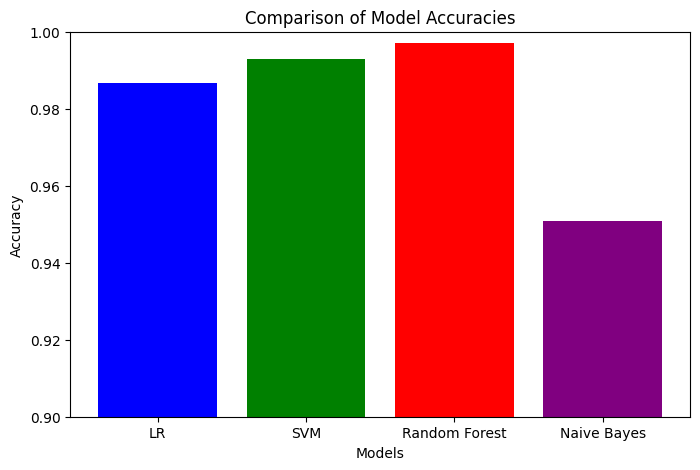

In [28]:
# Visualization
plt.figure(figsize=(8, 5))
plt.bar(['LR','SVM', 'Random Forest', 'Naive Bayes'], [accuracy_LR, svm_accuracy, rf_accuracy, nb_accuracy], color=['blue', 'green', 'red', 'purple'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.ylim(0.9, 1.0)
plt.show()


## LSTM-based deep learning model

In [31]:
# Encode labels
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Tokenization
max_words = 20000  # Vocabulary size
max_length = 500  # Max length of input sequences
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

# Build LSTM Model
model_lstm = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_length),
    SpatialDropout1D(0.2),
    LSTM(100, dropout=0.2, recurrent_dropout=0.2),
    Dense(1, activation='sigmoid')
])

# Compile model
model_lstm.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train model
model_lstm.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_data=(X_test_pad, y_test))


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 690s 1s/step - accuracy: 0.6619 - loss: 0.5920 - val_accuracy: 0.7941 - val_loss: 0.4854
Epoch 2/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 751s 1s/step - accuracy: 0.8163 - loss: 0.4333 - val_accuracy: 0.9542 - val_loss: 0.1401
Epoch 3/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 740s 1s/step - accuracy: 0.9709 - loss: 0.1005 - val_accuracy: 0.9941 - val_loss: 0.0237
Epoch 4/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 743s 1s/step - accuracy: 0.9935 - loss: 0.0283 - val_accuracy: 0.9916 - val_loss: 0.0316
Epoch 5/5
500/500 ━━━━━━━━━━━━━━━━━━━━ 744s 1s/step - accuracy: 0.9964 - loss: 0.0163 - val_accuracy: 0.9965 - val_loss: 0.0158


In [32]:
# Evaluate model
loss, accuracy_lstm = model_lstm.evaluate(X_test_pad, y_test)
print(f"Validation Loss: {loss}, Validation Accuracy: {accuracy_lstm}")

250/250 ━━━━━━━━━━━━━━━━━━━━ 45s 180ms/step - accuracy: 0.9976 - loss: 0.0128
Validation Loss: 0.015787813812494278, Validation Accuracy: 0.9964951872825623


In [33]:
#Evaluate Model on Validation Data
y_pred = model_lstm.predict(X_test_pad)
y_pred = (y_pred > 0.5).astype(int)
print("Model Accuracy:", accuracy_score(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

250/250 ━━━━━━━━━━━━━━━━━━━━ 46s 183ms/step
Model Accuracy: 0.9964951808737014
Classification Report:
               precision    recall  f1-score   support

           0       0.99      1.00      1.00      3989
           1       1.00      0.99      1.00      4000

    accuracy                           1.00      7989
   macro avg       1.00      1.00      1.00      7989
weighted avg       1.00      1.00      1.00      7989



In [39]:
# Save the LSTM model
model_lstm.save("lstm_model.keras")

# Load the LSTM model
loaded_lstm_model = load_model("lstm_model.keras")

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 8 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


## CNN model

In [43]:
# CNN Model
max_words = 10000  # Reduced vocabulary size
max_length = 300  # Reduced max sequence length
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train) # creates a word-to-index dictionary.
#  replaces words with their corresponding indexes.
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)
X_train_pad = pad_sequences(X_train_seq, maxlen=max_length, padding='post', truncating='post') #pad_sequences ensures all input sequences have the same length
X_test_pad = pad_sequences(X_test_seq, maxlen=max_length, padding='post', truncating='post')

'''
Why Not Use TF-IDF for CNN?

TF-IDF results in sparse, high-dimensional data, which isn't suitable for CNNs.
CNNs work best with dense, sequential representations (like word embeddings).
'''

model_cnn = Sequential([
    Embedding(input_dim=max_words, output_dim=128, input_length=max_length),
    SpatialDropout1D(0.2),
    Conv1D(filters=64, kernel_size=5, activation='relu'),  # Reduced filters
    MaxPooling1D(pool_size=2),
    Conv1D(filters=32, kernel_size=3, activation='relu'),  # Reduced filters
    GlobalMaxPooling1D(),  # Replaced Flatten with GlobalMaxPooling1D
    Dense(64, activation='relu'),  # Reduced dense layer size
    Dense(1, activation='sigmoid')
])

model_cnn.compile(loss='binary_crossentropy', optimizer='adamax', metrics=['accuracy'])  # Switched to Adamax optimizer

history = model_cnn.fit(X_train_pad, y_train, epochs=5, batch_size=128, validation_data=(X_test_pad, y_test))  # Reduced epochs, increased batch size


Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


250/250 ━━━━━━━━━━━━━━━━━━━━ 86s 331ms/step - accuracy: 0.7814 - loss: 0.4444 - val_accuracy: 0.9960 - val_loss: 0.0181
Epoch 2/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 84s 335ms/step - accuracy: 0.9954 - loss: 0.0191 - val_accuracy: 0.9969 - val_loss: 0.0126
Epoch 3/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 174s 463ms/step - accuracy: 0.9972 - loss: 0.0116 - val_accuracy: 0.9974 - val_loss: 0.0098
Epoch 4/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 112s 342ms/step - accuracy: 0.9973 - loss: 0.0090 - val_accuracy: 0.9981 - val_loss: 0.0084
Epoch 5/5
250/250 ━━━━━━━━━━━━━━━━━━━━ 140s 335ms/step - accuracy: 0.9979 - loss: 0.0072 - val_accuracy: 0.9984 - val_loss: 0.0065


In [44]:
loss, accuracy_cnn = model_cnn.evaluate(X_test_pad, y_test)
print(f"CNN Model Accuracy: {accuracy_cnn:.4f}")


250/250 ━━━━━━━━━━━━━━━━━━━━ 6s 23ms/step - accuracy: 0.9988 - loss: 0.0050
CNN Model Accuracy: 0.9984


In [45]:
# Save the CNN model
model_cnn.save("cnn_model.keras")

In [46]:
# Load the CNN model
loaded_cnn_model = load_model("cnn_model.keras")

## Visualization

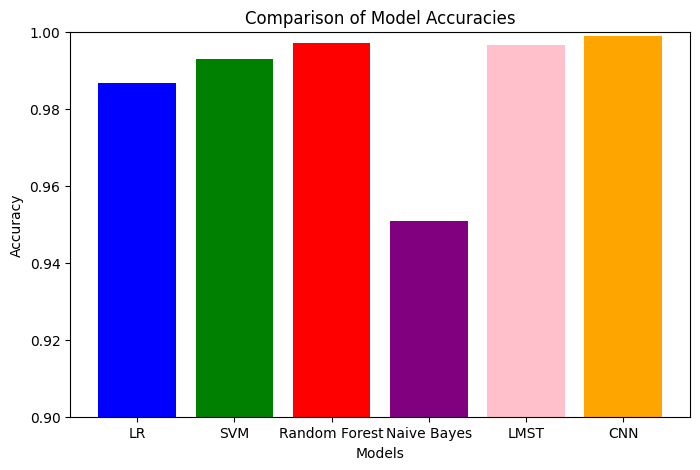

In [40]:
# Visualization
plt.figure(figsize=(8, 5))
plt.bar(['LR','SVM', 'Random Forest', 'Naive Bayes', 'LMST', 'CNN'], [accuracy_LR, svm_accuracy, rf_accuracy, nb_accuracy, accuracy_lstm, accuracy_cnn],
        color=['blue', 'green', 'red', 'purple', 'pink', 'orange'])
plt.xlabel("Models")
plt.ylabel("Accuracy")
plt.title("Comparison of Model Accuracies")
plt.ylim(0.9, 1.0)
plt.show()

Best Model: CNN 99.84% It achieved the highest accuracy.



If we want the speed and accuracy, Random Forest is the best choice.
If we want to explore deep learning further, CNN is still very strong.

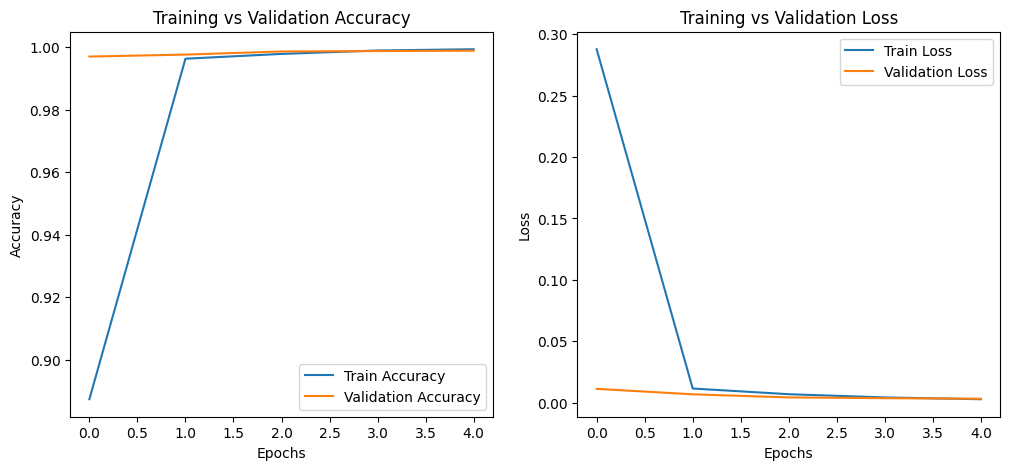

In [41]:
# Visualization
plt.figure(figsize=(12, 5))

# Plot training & validation accuracy
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training vs Validation Accuracy')
plt.legend()

# Plot training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training vs Validation Loss')
plt.legend()

plt.show()

#  Use the CNN model to predict labels

In [47]:
# Transform validation text using the trained TF-IDF vectorizer
X_validation = (Val_data_copy['title'].fillna("") + " " + Val_data_copy['text'].fillna(""))
X_validation_tfidf = tfidf_vectorizer.transform(X_validation)

# Predict labels using CNN model
validation_predictions = loaded_cnn_model.predict(X_validation_tfidf)

# Replace label 2 with predicted values
Val_data_copy['label'] = [pred if lbl == 2 else lbl for lbl, pred in zip(Val_data_copy['label'], validation_predictions)]

# Save the updated validation dataset
Val_data_copy.to_csv("validation_data_CNN.csv", index=False)

155/155 ━━━━━━━━━━━━━━━━━━━━ 146s 938ms/step


In [48]:
val_data_cnn = pd.read_csv('validation_data_CNN.csv')
val_data_cnn.shape

(4956, 5)

In [49]:
val_data_cnn.head()

,label,title,text,subject,date
0,1,UK's May 'receiving regular updates' on London...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"September 15, 2017"
1,1,UK transport police leading investigation of L...,LONDON (Reuters) - British counter-terrorism p...,worldnews,"September 15, 2017"
2,1,Pacific nations crack down on North Korean shi...,WELLINGTON (Reuters) - South Pacific island na...,worldnews,"September 15, 2017"
3,1,Three suspected al Qaeda militants killed in Y...,"ADEN, Yemen (Reuters) - Three suspected al Qae...",worldnews,"September 15, 2017"
4,1,Chinese academics prod Beijing to consider Nor...,BEIJING (Reuters) - Chinese academics are publ...,worldnews,"September 15, 2017"


In [50]:
val_data_cnn.tail()

,label,title,text,subject,date
4951,0,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
4952,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
4953,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
4954,0,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"
4955,0,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016"


Visualize the predictions

<ipython-input-51-dfcae8dcb40e>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=news_data_cp['label'], palette='viridis')


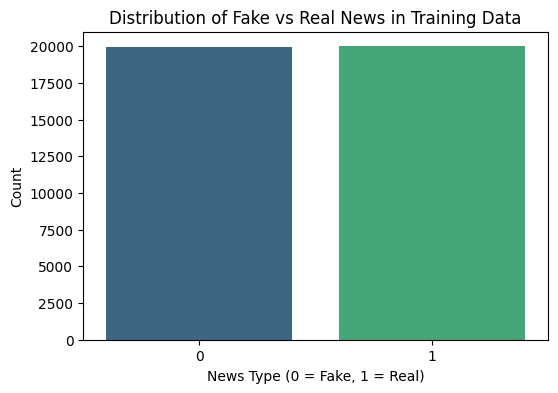

<ipython-input-51-dfcae8dcb40e>:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=val_data_cnn['label'], palette='magma')


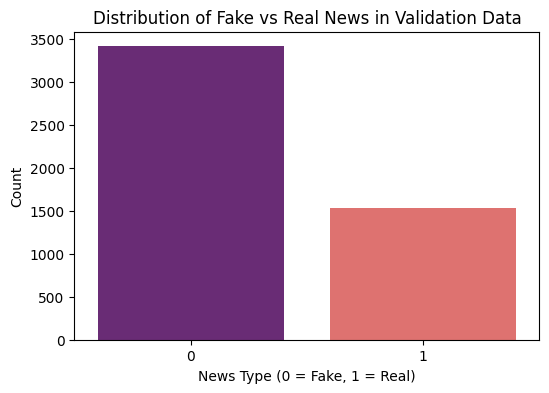

In [51]:
# Visualizing fake vs real news distribution in news_data
plt.figure(figsize=(6,4))
sns.countplot(x=news_data_cp['label'], palette='viridis')
plt.xlabel("News Type (0 = Fake, 1 = Real)")
plt.ylabel("Count")
plt.title("Distribution of Fake vs Real News in Training Data")
plt.show()

# Visualizing fake vs real news distribution in validation_data
plt.figure(figsize=(6,4))
sns.countplot(x=val_data_cnn['label'], palette='magma')
plt.xlabel("News Type (0 = Fake, 1 = Real)")
plt.ylabel("Count")
plt.title("Distribution of Fake vs Real News in Validation Data")
plt.show()

# Build a Word2Vec

In [21]:
texts = news_data_cp['title'] + " " + news_data_cp['text']
labels = news_data_cp['label']

Training the Word2Vec model on text data

In [22]:
def train_word2vec(texts, vector_size=300, window=5, min_count=1, workers=4):
    tokenized_texts = [text.split() for text in texts]
    model_w2v = Word2Vec(sentences=tokenized_texts, vector_size=vector_size, window=window, min_count=min_count, workers=workers)
    return model_w2v

word2vec_model = train_word2vec(texts)

Convert texts to vectors using average embedding (for classic models)


In [23]:
def get_average_word_vectors(texts, model, vector_size=300):
    vectors = []
    for text in texts:
        words = text.split()
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if word_vectors:
            avg_vector = np.mean(word_vectors, axis=0)  # Average calculation
        else:
            avg_vector = np.zeros(vector_size)
        vectors.append(avg_vector)
    return np.array(vectors)

X_avg = get_average_word_vectors(texts, word2vec_model)

## Training the model (Logistic Regression)

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_avg, labels, test_size=0.2, random_state=42)

In [25]:
clf = LogisticRegression()
clf.fit(X_train, y_train)
# Transform validation text using the trained TF-IDF vectorizer
X_validation = (Val_data_copy['title'].fillna("") + " " + Val_data_copy['text'].fillna(""))
X_validation_tfidf = tfidf_vectorizer.transform(X_validation)
y_pred = clf.predict(X_validation_tfidf)

print("Accuracy (Logistic Regression):", accuracy_score(y_test, y_pred))
print(classification_report(y_test, y_pred))

Accuracy (Logistic Regression): 0.9933658780823632
              precision    recall  f1-score   support

           0       0.99      0.99      0.99      3996
           1       0.99      0.99      0.99      3993

    accuracy                           0.99      7989
   macro avg       0.99      0.99      0.99      7989
weighted avg       0.99      0.99      0.99      7989



## Save the model

In [26]:
word2vec_model.wv.save("word2vec_model.kv")

In [29]:
joblib.dump(clf, "logistic_regression.pkl")

['logistic_regression.pkl']

## Prediction

In [32]:
word2vec_model = gensim.models.KeyedVectors.load("word2vec_model.kv", mmap='r')

In [33]:
# download Logistic Regression
logistic_model = joblib.load("logistic_regression.pkl")

 Convert texts to vectors using Word2Vec

In [34]:
import numpy as np

# Convert text to vector using Word2Vec
def text_to_vector(text, model):
    words = text.split()  # Divide the text into words
    word_vectors = [model[word] for word in words if word in model.key_to_index]

    if len(word_vectors) > 0:
        return np.mean(word_vectors, axis=0)  # Take the average to represent the entire text
    else:
        return np.zeros(model.vector_size)  # Return zero if no word is found


X_validation = np.array([text_to_vector(text, word2vec_model) for text in Val_data_copy["text"]])


print(X_validation.shape)

(4956, 300)


Predicting using logistic regression

In [35]:
clf = joblib.load("logistic_regression.pkl")

predictions = clf.predict(X_validation)

Val_data_copy["label"] = predictions
Val_data_copy["label"] = Val_data_copy["label"].replace({2: 0})
Val_data_copy.to_csv("validation_predictions.csv", index=False)

In [37]:
val_pred= pd.read_csv('validation_predictions.csv')
val_pred.head()

,label,title,text,subject,date
0,1,UK's May 'receiving regular updates' on London...,LONDON (Reuters) - British Prime Minister Ther...,worldnews,"September 15, 2017"
1,1,UK transport police leading investigation of L...,LONDON (Reuters) - British counter-terrorism p...,worldnews,"September 15, 2017"
2,1,Pacific nations crack down on North Korean shi...,WELLINGTON (Reuters) - South Pacific island na...,worldnews,"September 15, 2017"
3,1,Three suspected al Qaeda militants killed in Y...,"ADEN, Yemen (Reuters) - Three suspected al Qae...",worldnews,"September 15, 2017"
4,1,Chinese academics prod Beijing to consider Nor...,BEIJING (Reuters) - Chinese academics are publ...,worldnews,"September 15, 2017"


In [38]:
val_pred.tail()

,label,title,text,subject,date
4951,0,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
4952,0,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
4953,0,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
4954,0,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"
4955,0,10 U.S. Navy Sailors Held by Iranian Military ...,21st Century Wire says As 21WIRE predicted in ...,Middle-east,"January 12, 2016"


<ipython-input-39-a4a6c6af1103>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=val_pred['label'], palette='magma')


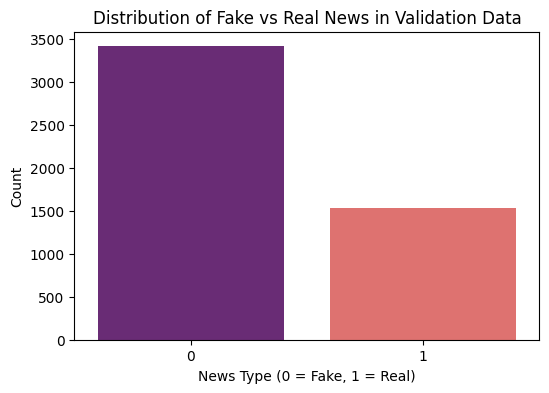

In [39]:
# Visualizing fake vs real news distribution in validation_data
plt.figure(figsize=(6,4))
sns.countplot(x=val_pred['label'], palette='magma')
plt.xlabel("News Type (0 = Fake, 1 = Real)")
plt.ylabel("Count")
plt.title("Distribution of Fake vs Real News in Validation Data")
plt.show()